<a href="https://colab.research.google.com/github/philippedebeaumont/spark_etl_on_gcp/blob/main/ml/prophet_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
# @title Setup
from google.colab import auth
from google.cloud import bigquery
from google.colab import data_table

project = 'london-bikes-ml' # Project ID inserted based on the query results selected to explore
location = 'europe-west9' # Location inserted based on the query results selected to explore
client = bigquery.Client(project=project, location=location)
data_table.enable_dataframe_formatter()
auth.authenticate_user()

## Reference SQL syntax from the original job
Use the ```jobs.query```
[method](https://cloud.google.com/bigquery/docs/reference/rest/v2/jobs/query) to
return the SQL syntax from the job. This can be copied from the output cell
below to edit the query now or in the future. Alternatively, you can use
[this link](https://console.cloud.google.com/bigquery?j=london-bikes-ml:europe-west9:bquxjob_c4b2d25_18926a59eed)
back to BigQuery to edit the query within the BigQuery user interface.

In [12]:
# Running this code will display the query used to generate your previous job

job = client.get_job('bquxjob_c4b2d25_18926a59eed') # Job ID inserted based on the query results selected to explore
print(job.query)

WITH query AS (SELECT DISTINCT start_date, hire_count, prcp, tavg FROM `london-bikes-ml.london_cycles_dataset.daily_agg`)
SELECT start_date, SUM(hire_count) AS hire_count, MAX(prcp)  AS prcp, MAX(tavg) AS tavg FROM query GROUP BY start_date ORDER BY start_date


# Result set loaded from BigQuery job as a DataFrame
Query results are referenced from the Job ID ran from BigQuery and the query
does not need to be re-run to explore results. The ```to_dataframe```
[method](https://googleapis.dev/python/bigquery/latest/generated/google.cloud.bigquery.job.QueryJob.html#google.cloud.bigquery.job.QueryJob.to_dataframe)
downloads the results to a Pandas DataFrame by using the BigQuery Storage API.

To edit query syntax, you can do so from the BigQuery SQL editor or in the
```Optional:``` sections below.

In [13]:
# Running this code will read results from your previous job

job = client.get_job('bquxjob_c4b2d25_18926a59eed') # Job ID inserted based on the query results selected to explore
results = job.to_dataframe()
results

,start_date,hire_count,prcp,tavg
0,2019-09-11,9802,0.0,17.500000
1,2019-09-12,11316,0.0,18.400000
2,2019-09-13,10538,0.0,17.600000
3,2019-09-14,10305,0.0,16.600000
4,2019-09-15,9534,0.0,18.400000
...,...,...,...,...
1090,2022-09-07,8285,19.1,17.200001
1091,2022-09-08,5663,7.9,15.700000
1092,2022-09-09,6609,7.9,16.700001
1093,2022-09-10,1,6.9,16.900000


## Show descriptive statistics using describe()
Use the ```pandas DataFrame.describe()```
[method](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html)
to generate descriptive statistics. Descriptive statistics include those that
summarize the central tendency, dispersion and shape of a dataset’s
distribution, excluding ```NaN``` values. You may also use other Python methods
to interact with your data.

In [14]:
results.describe()

,hire_count,prcp,tavg
count,1095.0,1086.000000,1095.000000
mean,7375.855708,1.783241,12.052877
std,4255.174654,3.786432,5.562269
min,1.0,0.000000,-1.300000
25%,4214.0,0.000000,7.600000
50%,6766.0,0.000000,11.600000
75%,10072.5,1.800000,16.600000
max,29361.0,33.299999,29.799999


In [15]:
import pandas as pd
from datetime import date
df = pd.DataFrame()
df["ds"] = results["start_date"][results["start_date"] < date(2022,1,1)]
df["y"] = results["hire_count"][results["start_date"] < date(2022,1,1)]
df["prcp"] = results["prcp"][results["start_date"] < date(2022,1,1)]
df["tavg"] = results["tavg"][results["start_date"] < date(2022,1,1)]
df = df.fillna(0.0)

In [16]:
df.isna().sum()

ds      0
y       0
prcp    0
tavg    0
dtype: int64

In [17]:
from prophet import Prophet

In [18]:
model = Prophet()
model.add_regressor('prcp')
model.add_regressor('tavg')
model.fit(df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpw1nrncai/0wm5_b5q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpw1nrncai/ix_nwcay.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71950', 'data', 'file=/tmp/tmpw1nrncai/0wm5_b5q.json', 'init=/tmp/tmpw1nrncai/ix_nwcay.json', 'output', 'file=/tmp/tmpw1nrncai/prophet_model4pab78yj/prophet_model-20230706072423.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:24:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:24:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [25]:
future = model.make_future_dataframe(periods=250)
test_data = pd.DataFrame()
test_data["prcp"] = pd.concat([results["prcp"][results["start_date"] < date(2022,1,1)], results["prcp"][results["start_date"] >= date(2022,1,1)][:250]])
test_data["tavg"] = pd.concat([results["tavg"][results["start_date"] < date(2022,1,1)], results["tavg"][results["start_date"] >= date(2022,1,1)][:250]])
test_data = test_data.fillna(0.0)

In [26]:
len(future)

1091

In [27]:
future

,ds
0,2019-09-11
1,2019-09-12
2,2019-09-13
3,2019-09-14
4,2019-09-15
...,...
1086,2022-09-03
1087,2022-09-04
1088,2022-09-05
1089,2022-09-06


In [28]:
test_data.isna().sum()

prcp    0
tavg    0
dtype: int64

In [29]:
future['prcp'] = test_data["prcp"]
future['tavg'] = test_data["tavg"]
future.tail()

,ds,prcp,tavg
1086,2022-09-03,0.0,18.700001
1087,2022-09-04,8.9,19.799999
1088,2022-09-05,2.5,19.200001
1089,2022-09-06,8.9,17.600000
1090,2022-09-07,19.1,17.200001


In [30]:
future.isna().sum()

ds      0
prcp    0
tavg    0
dtype: int64

In [31]:
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1086,2022-09-03,13860.675779,10057.783895,17515.860107
1087,2022-09-04,11952.951505,7994.155872,15769.951692
1088,2022-09-05,11067.348947,7491.873107,14809.092736
1089,2022-09-06,10004.452939,6436.644016,13803.905682
1090,2022-09-07,8444.807549,4937.211798,12240.083051


In [36]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,extra_regressors_additive,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-09-11,6846.133731,6407.025808,13959.916344,6846.133731,6846.133731,3395.591660,3395.591660,3395.591660,2127.567863,...,-372.776455,-372.776455,-372.776455,1640.800252,1640.800252,1640.800252,0.0,0.0,0.0,10241.725391
1,2019-09-12,6845.770331,6867.069007,14207.027946,6845.770331,6845.770331,3504.661531,3504.661531,3504.661531,2405.819247,...,-536.742569,-536.742569,-536.742569,1635.584853,1635.584853,1635.584853,0.0,0.0,0.0,10350.431862
2,2019-09-13,6845.406931,6282.542036,13826.581837,6845.406931,6845.406931,3322.344957,3322.344957,3322.344957,2158.484814,...,-453.609981,-453.609981,-453.609981,1617.470124,1617.470124,1617.470124,0.0,0.0,0.0,10167.751889
3,2019-09-14,6845.043531,8366.708599,15771.336751,6845.043531,6845.043531,5260.995728,5260.995728,5260.995728,1849.316479,...,1825.206154,1825.206154,1825.206154,1586.473095,1586.473095,1586.473095,0.0,0.0,0.0,12106.039259
4,2019-09-15,6844.680131,7849.211376,15506.943519,6844.680131,6844.680131,4854.108093,4854.108093,4854.108093,2405.819247,...,905.458144,905.458144,905.458144,1542.830702,1542.830702,1542.830702,0.0,0.0,0.0,11698.788224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1086,2022-09-03,8235.296493,10057.783895,17515.860107,8159.338491,8304.500553,5625.379286,5625.379286,5625.379286,2498.570102,...,1825.206154,1825.206154,1825.206154,1301.603031,1301.603031,1301.603031,0.0,0.0,0.0,13860.675779
1087,2022-09-04,8237.697542,7994.155872,15769.951692,8161.193962,8307.389644,3715.253963,3715.253963,3715.253963,1434.496144,...,905.458144,905.458144,905.458144,1375.299675,1375.299675,1375.299675,0.0,0.0,0.0,11952.951505
1088,2022-09-05,8240.098591,7491.873107,14809.092736,8163.054193,8310.220052,2827.250356,2827.250356,2827.250356,2258.727664,...,-873.792161,-873.792161,-873.792161,1442.314853,1442.314853,1442.314853,0.0,0.0,0.0,11067.348947
1089,2022-09-06,8242.499641,6436.644016,13803.905682,8164.901783,8313.440607,1761.953299,1761.953299,1761.953299,754.326159,...,-493.743131,-493.743131,-493.743131,1501.370270,1501.370270,1501.370270,0.0,0.0,0.0,10004.452939


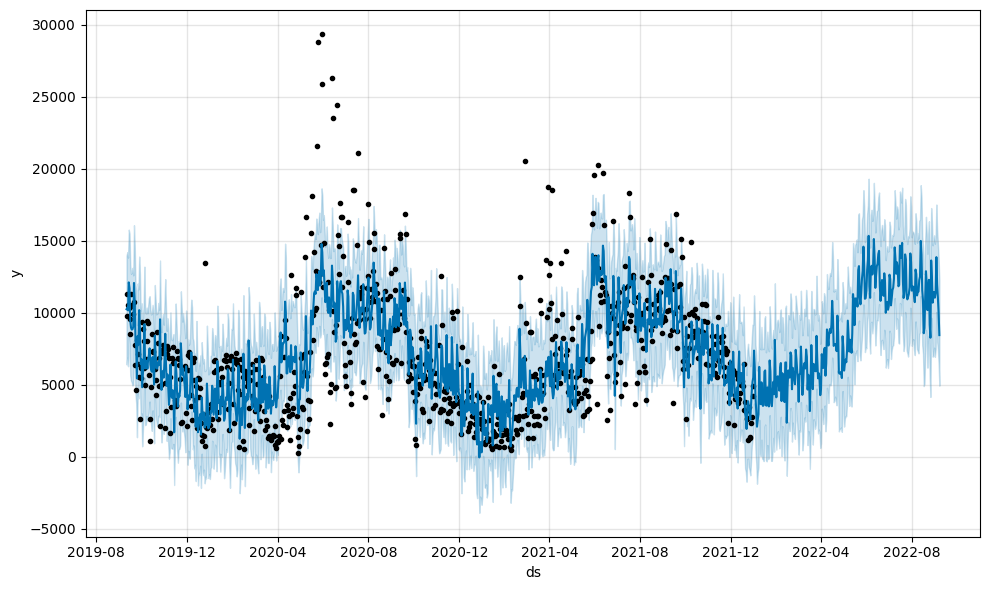

In [45]:
fig1 = model.plot(forecast)

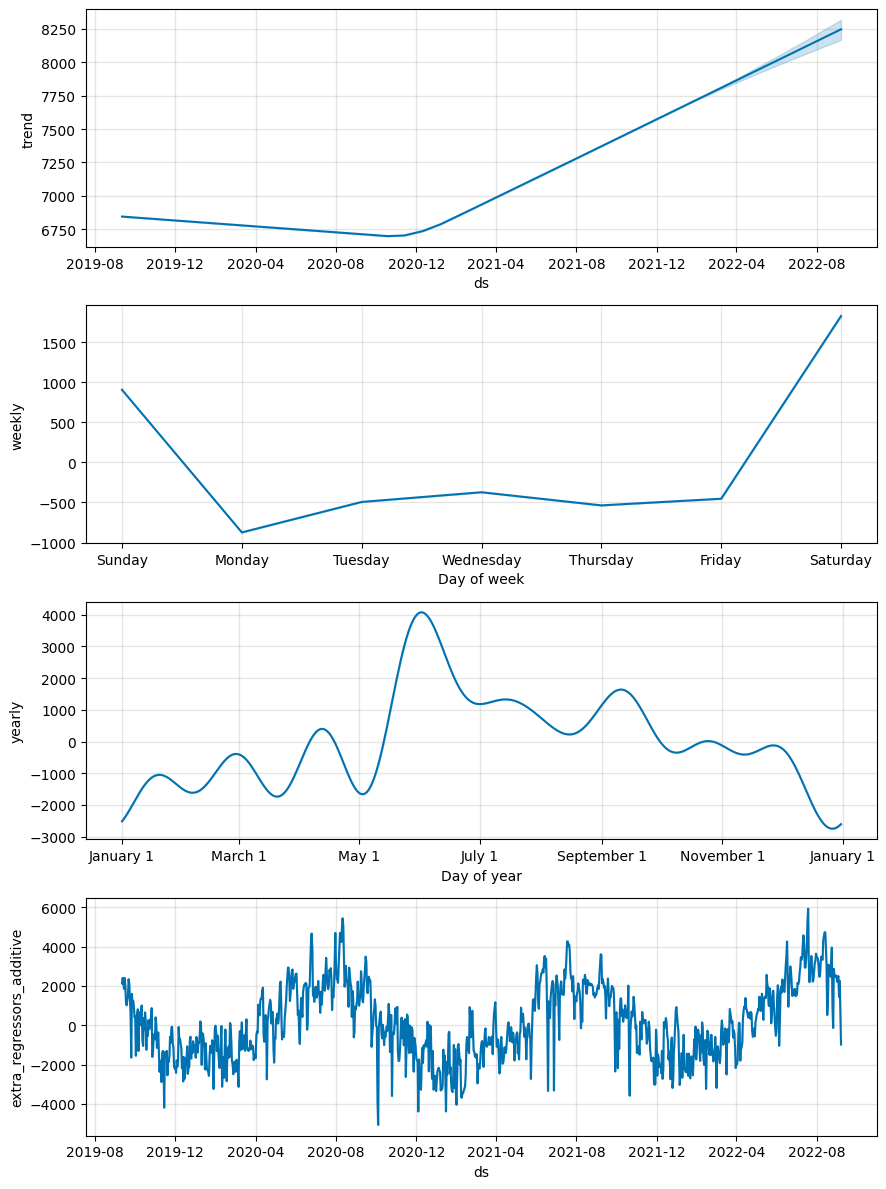

In [33]:
fig2 = model.plot_components(forecast)

In [34]:
testo_data = pd.DataFrame()
testo_data = pd.DataFrame()
testo_data["ds"] = results["start_date"][results["start_date"] >= date(2022,1,1)][:250]
testo_data["y"] = results["hire_count"][results["start_date"] >= date(2022,1,1)][:250]

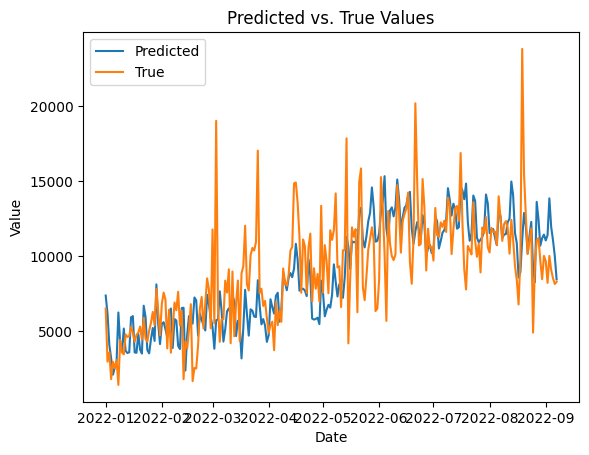

In [51]:
import matplotlib.pyplot as plt
true_values = pd.concat([results['hire_count'][results["start_date"] < date(2022,1,1)], results['hire_count'][results["start_date"] >= date(2022,1,1)][:250]])

# Combine the predicted and true values into a new DataFrame
combined_data = forecast[['ds', 'yhat']].join(true_values)

combined_data = combined_data[-250:]

# Plot the combined values
plt.plot(combined_data['ds'], combined_data['yhat'], label='Predicted')
plt.plot(combined_data['ds'], combined_data['hire_count'], label='True')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Predicted vs. True Values')
plt.show()

In [39]:
import numpy as np

def smape(actual, predicted):
    """
    Calculate the Symmetric Mean Absolute Percentage Error (SMAPE) between actual and predicted values.

    Args:
        actual (array-like): Array of actual values.
        predicted (array-like): Array of predicted values.

    Returns:
        float: The SMAPE value.
    """
    actual = np.array(actual)
    predicted = np.array(predicted)

    numerator = np.abs(actual - predicted)
    denominator = (np.abs(actual) + np.abs(predicted)) / 2

    smape_score = np.mean(numerator / denominator) * 100

    return smape_score

In [42]:
smape(forecast["yhat"][len(forecast) - 250:], testo_data["y"])

24.424965073034798